## Generating spike trains with a refractory period

BMTK's built-in SpikeGenerator options offer a convenient way to generate spike trains that you can send to virtual nodes in your network. You have already seen in some of the tutorials how to generate a simple Poisson spike train. This tutorial demonstrates some variants that generate more realistic spike trains by incorporating a refractory period. The first part uses a method starting from a Poisson process but removing spikes occurring during the refractory period. The second part uses the GammaSpikeGenerator to directly generate spike trains with refractory properties. 

### Poisson Spike Generator
Let's start by creating Poisson spike trains with a firing rate of 20 Hz for 50 model cells and examine the distribution of interspike intervals.   

Actual Firing Rate (Hz): 19.84


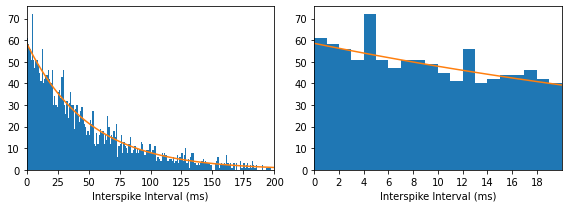

In [1]:
import pytest
import numpy as np
import os
from matplotlib import pyplot as plt
import warnings

from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from bmtk.utils.reports.spike_trains import SpikeTrains

def plot_isi(psg, lam=20/1000, plotline=False):
    df = psg.to_dataframe()
    isi = np.empty([0])
    for n in psg.node_ids():
        spk_times = df[df['node_ids']==n]['timestamps']
        isi = np.append(isi, np.diff(np.array(spk_times)))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
    edges = np.arange(0,201,1)
    ax[0].hist(isi, bins=edges)
    ax[0].set_xlim((0, 200))
    ax[0].set_xlabel('Interspike Interval (ms)')
    
    edges = np.arange(0,22,1)
    ax[1].hist(isi/(edges[1]-edges[0]), bins=edges)
    ax[1].set_xlim((0, 20))
    ax[1].set_xlabel('Interspike Interval (ms)')
    ax[1].set_xticks(np.arange(0,20,2))

    fig.tight_layout()
    counts, bins = np.histogram(isi,bins=40)
    
    if plotline:
        x = np.arange(0,201,1)
        y = np.zeros(x.shape[0])
        y = lam*np.exp(-lam*x)*len(isi)
        ax[0].plot(x,y)
        ax[1].plot(x[:22],y[:22])
    
    
start_time = 0.0
end_time = 3.0
nodes = range(50)

psg = PoissonSpikeGenerator(population='test', seed=200)
psg.add(node_ids=nodes, firing_rate=20.0, times=(start_time, end_time))
plot_isi(psg, plotline=True)

actual_fr = psg.n_spikes()/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')

On the left, we see the interspike interval (ISI) histogram over the range from 0 to 200 ms, normalized by the bin width. This approaches the expected exponential distribution for the density function of inter-event times in a Poisson process. On the right side, we plot a close up of the region between 0 and 20 ms and note that there is no refractory period. 

Next, we can use the ```abs_ref``` parameter to add a 2 ms absolute refractory period and notice an effect on the ISI histogram below 2 ms (no spikes are allowed). This method of removing spikes with intervals below the absolute refractory period reduces the effective firing rate. BMTK attempts to correct for this such that the intended firing rate is achieved, but is only able to do so up to a maximal firing rate limit (in this case about 184 Hz) above which an error will be thrown. If high firing rates are desired, consider the GammaSpikeGenerator described in the second part of this tutorial.

Actual Firing Rate (Hz): 19.673333333333332


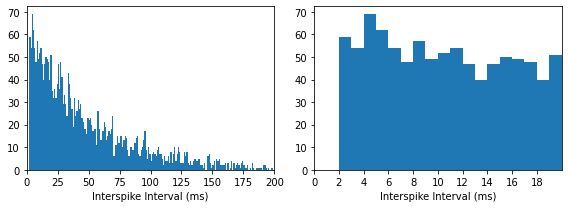

In [2]:
psg = PoissonSpikeGenerator(population='test', seed=200)
psg.add(node_ids=nodes, firing_rate=20.0, times=(start_time, end_time), abs_ref=0.002)
plot_isi(psg)

actual_fr = psg.n_spikes()/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')

Now let's add a relative refractory period modeled as a reduced probability of firing that exponentially approaches 1 with a time constant of 3 ms, starting from after the absolute refractory period.

Actual Firing Rate (Hz): 20.186666666666667


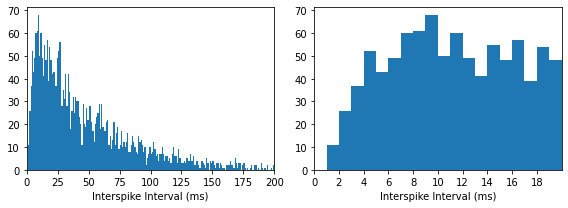

In [3]:
psg = PoissonSpikeGenerator(population='test', seed=200)
psg.add(node_ids=nodes, firing_rate=20, times=(start_time, end_time), abs_ref=0.001, tau_ref= 0.003)
plot_isi(psg)

actual_fr = psg.n_spikes()/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')

We can also use a time-varying firing rate to generate an inhomogeneous Poisson spike train and add refractory properties in the same way. The top panels show the ISI distribution, and the bottom panels show the intended firing rate and the PSTH of the generated spike train.

Actual Firing Rate (Hz): 24.646666666666665


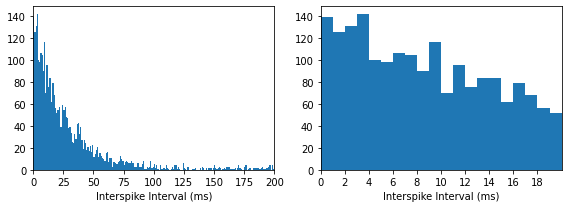

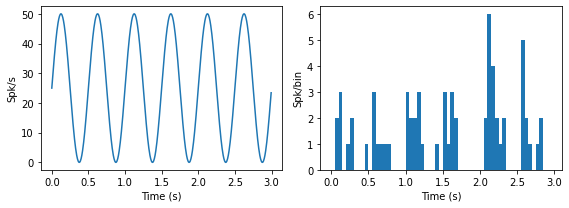

In [4]:
# Test Poisson spike generator inhomogeneous with abs and rel refractory periods

fr_t = np.arange(start_time, end_time, 0.005)
fr_vec = 25+25*np.sin(2*np.pi*2*fr_t)

psg = PoissonSpikeGenerator(population='test', seed=200)
psg.add(node_ids=nodes, firing_rate=fr_vec, times=fr_t)
# Added an exception so this is no longer valid:
# psg.add(node_ids=nodes, firing_rate=fr_vec, times=(start_time, end_time))
plot_isi(psg)

actual_fr = psg.n_spikes()/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')

df = psg.to_dataframe()
spk_times = df[df['node_ids']==0]['timestamps']
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(fr_t,fr_vec)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Spk/s')
edges = np.arange(0,3000,50)   # 50 ms bins should have on average 50/20 = 2.5 sp/bin
ax[1].hist(spk_times/1000, bins=edges/1000)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Spk/bin')
fig.tight_layout()

Similarly, we can apply an absolute and relative refractory period to the inhomogeneous spike train:

Actual Firing Rate (Hz): 22.226666666666667


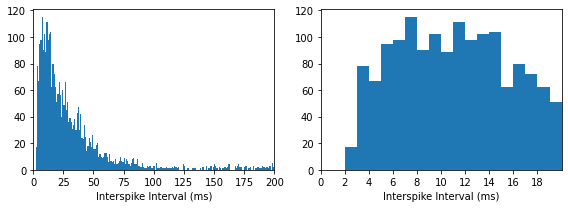

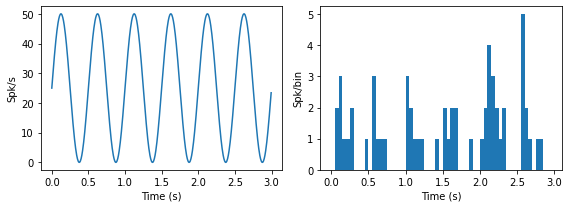

In [5]:
psg = PoissonSpikeGenerator(population='test', seed=200)
psg.add(node_ids=nodes, firing_rate=fr_vec, times=fr_t, abs_ref=0.002, tau_ref=0.003)
plot_isi(psg)

actual_fr = psg.n_spikes()/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')

df = psg.to_dataframe()
spk_times = df[df['node_ids']==0]['timestamps']
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(fr_t,fr_vec)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Spk/s')
edges = np.arange(0,3000,50)   # 50 ms bins should have on average 50/20 = 2.5 sp/bin
ax[1].hist(spk_times/1000, bins=edges/1000)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Spk/bin')
fig.tight_layout()

### Gamma Spike Generator

An alternative way to simulates a relative refractory period is to use a Gamma renewal process rather than a Poisson process.

The refractory properties are controlled by the shape parameter ```a```. To give an intuitive sense of the effect of the shape parameter, the distributions for a range of ```a``` values is plotted below. Larger values of ```a``` correspond to slower recovery.

Text(110, 207.06, 'Shape parameter = 1.9')

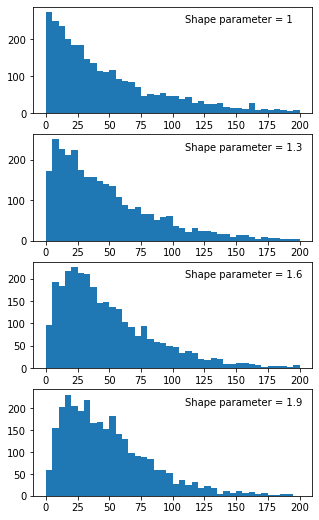

In [6]:
from scipy.stats import gamma

fr = 20.0
binsize = 5
bin_list = np.arange(0,202,binsize)

a = 1 # Exponential, i.e., Poisson process for a = 1 
r = gamma.rvs(a,loc=0, scale=1/(a*fr), size=3000)

fig, ax = plt.subplots(4, figsize =(5,9))
ax[0].hist(r*1000, bins=bin_list)
yl = ax[0].get_ylim()
ax[0].text(110, 0.85*yl[1], 'Shape parameter = {shape}'.format(shape = a))

a = 1.3
r = gamma.rvs(a,loc=0, scale=1/(a*fr), size=3000)
ax[1].hist(r*1000, bins=bin_list)
yl = ax[1].get_ylim()
ax[1].text(110, 0.85*yl[1], 'Shape parameter = {shape}'.format(shape = a))

a = 1.6
r = gamma.rvs(a,loc=0, scale=1/(a*fr), size=3000)
ax[2].hist(r*1000, bins=bin_list)
yl = ax[2].get_ylim()
ax[2].text(110, 0.85*yl[1], 'Shape parameter = {shape}'.format(shape = a))

a = 1.9
r = gamma.rvs(a,loc=0, scale=1/(a*fr), size=3000)
ax[3].hist(r*1000, bins=bin_list)
yl = ax[3].get_ylim()
ax[3].text(110, 0.85*yl[1], 'Shape parameter = {shape}'.format(shape = a))


We can use the GammaSpikeGenerator to generate spike trains by specifying the desired firing rate and shape parameter values:

Actual Firing Rate (Hz): 22.226666666666667


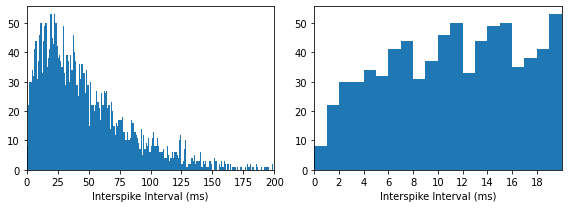

In [7]:
from bmtk.utils.reports.spike_trains import GammaSpikeGenerator

gsg = GammaSpikeGenerator(population='test', seed=100)
gsg.add(node_ids=nodes, firing_rate=20.0, a=1.5, times=(start_time, end_time))
plot_isi(gsg)

actual_fr = psg.n_spikes()/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')

### Application to Coefficient of Variation

One way that we can see the effect of the refractory period is on the regularity of the spiking pattern, which is often measured using the coefficient of variation (CV) of the ISI's.

A perfect Poisson process should have a CV of 1, regardless of the firing rate. Indeed that is what we see, plus some noisiness.

(0.0, 1.1)

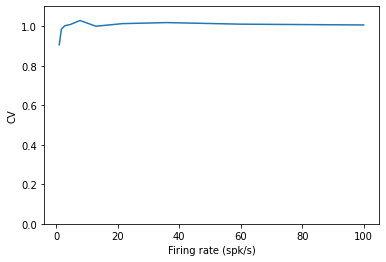

In [8]:
def cv(psg):
    df = psg.to_dataframe()
    isi = np.empty([0])
    for n in psg.node_ids():
        spk_times = df[df['node_ids']==n]['timestamps']
        isi = np.append(isi, np.diff(np.array(spk_times)))
    return np.std(isi)/np.mean(isi)

frs = np.logspace(0,2,10)
cvs = np.empty(frs.shape)
for i, fr in enumerate(frs):
    psg = PoissonSpikeGenerator(population='test', seed=200)
    psg.add(node_ids=nodes, firing_rate=fr, times=(start_time, end_time))
    cvs[i] = cv(psg)
    
plt.plot(frs, cvs)
plt.ylabel('CV')
plt.xlabel('Firing rate (spk/s)')
plt.ylim((0,1.1))

However, when we add a refractory period, we see that the CV drops and the firing pattern becomes more regular with increased firing rate. The intervals are short due to the high firing rate, yet they cannot be too short due to than the refractory period, compressing the ISI distribution.  

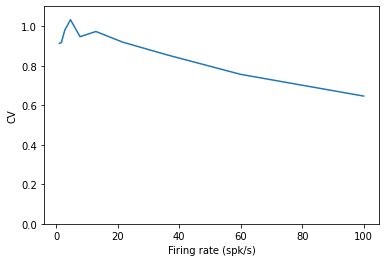

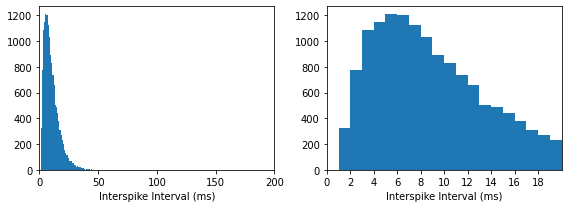

In [9]:
frs = np.logspace(0,2,10)
cvs = np.empty(frs.shape)
for i, fr in enumerate(frs):
    psg = PoissonSpikeGenerator(population='test', seed=200)
    psg.add(node_ids=nodes, firing_rate=fr, times=(start_time, end_time), abs_ref=0.001, tau_ref= 0.003)
    cvs[i] = cv(psg)
    
plt.plot(frs, cvs)
plt.ylabel('CV')
plt.xlabel('Firing rate (spk/s)')
plt.ylim((0,1.1))

plot_isi(psg)